In [3]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed

from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspologic.plot import heatmap
from sklearn.manifold import Isomap
import piecewise_regression
from sklearn.linear_model import LinearRegression


plt.ion()


def filter_matrix_TC(data, well):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well]['win_0']['adj_matrix_predicted']
    votes = data[well]['win_0']['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well]['win_0']['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

import warnings

def find_optimal_neighbors(X):
    n_neighbors = 2
    while True:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                isomap = Isomap(n_neighbors=n_neighbors)
                isomap.fit(X)
                print(f"Successful with n_neighbors={n_neighbors}")
                return n_neighbors
        except Warning as w:
            print(f"Warning encountered with n_neighbors={n_neighbors}: {w}")
            n_neighbors += 1


In [4]:
## data's path and name together
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/2024May28 No window data /OneDrive_1_6-17-2024/Run_8_TBS_Experiment_ecr_results/'

os.chdir(dr)

dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))

sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]

filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]
sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

len(sorted_filenames_updated)
#sorted_filenames_updated


36

In [5]:
well='well003'

well_number = int(well[4:])+1
print(well_number)

4


In [6]:
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

stimulus_time=df[df[str(well_number)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]

In [7]:
## read in all the time series of graphs
all_adj = []
num_vertices = []
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    adj = filter_matrix_TC(data, well)
    all_adj.append(adj)
    num_vertices.append(adj.shape[0])
    print(i,sum(sum(adj)), adj.shape[0] )


0 22163 936
1 23405 935
2 19708 934
3 20723 940
4 11436 909
5 21830 930
6 21525 944
7 20830 935
8 23102 939
9 22506 925
10 13730 925
11 23617 932
12 11850 913
13 12899 912
14 13569 896
15 12214 907
16 10777 911
17 22986 937
18 21397 931
19 7112 922
20 6556 920
21 10245 913
22 955 687
23 12045 926
24 11202 918
25 4195 929
26 7815 919
27 23640 928
28 3794 922
29 22941 935
30 20822 941
31 21955 934
32 10252 913
33 23458 932
34 8886 903
35 9049 909


In [149]:
#s,u=np.linalg.eig(all_adj[1])
#plt.scatter(range(all_adj[1].shape[0]),s)

In [8]:
## add zeros to the adj mat such that they have the same dims 
dim = max(num_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [9]:
graph_matching=True

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

Frob diff before GM: 200.47942537826668, After GM: 125.45915670049756,OFV before GM: 2688.0, After GM: 14914.0
Frob diff before GM: 202.75354497517424, After GM: 124.65552534885889,OFV before GM: 1002.0, After GM: 13787.0
Frob diff before GM: 195.99234678935807, After GM: 121.83185133617563,OFV before GM: 1009.0, After GM: 12794.0
Frob diff before GM: 177.70481141488546, After GM: 122.5275479229059,OFV before GM: 290.0, After GM: 8573.0
Frob diff before GM: 180.033330247485, After GM: 124.73171208638162,OFV before GM: 427.0, After GM: 8854.0
Frob diff before GM: 203.2707553978191, After GM: 130.05767951182276,OFV before GM: 1018.0, After GM: 13220.0
Frob diff before GM: 203.18218425836454, After GM: 133.41289293018121,OFV before GM: 536.0, After GM: 12278.0
Frob diff before GM: 205.53831759552767, After GM: 130.65221008463652,OFV before GM: 843.0, After GM: 13431.0
Frob diff before GM: 210.72731194603134, After GM: 123.76590806841762,OFV before GM: 601.0, After GM: 15145.0
Frob diff be

In [10]:
choosen_time_points=range(m)
from scipy.linalg import orthogonal_procrustes
tm=choosen_time_points

D=np.zeros([len(tm),len(tm)])

In [11]:
Pairwise_lccc=True

for i in range(len(tm)):
    for j in range(len(tm)):
        prod=adj_gm[choosen_time_points[i]] * adj_gm[choosen_time_points[j]]
        [a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
        n=len(ind)
        print(i,j,n)
        glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
        glist[i]=adj_gm[choosen_time_points[i]][ind][:,ind]
        glist[j]=adj_gm[choosen_time_points[j]][ind][:,ind]
        #print(graspologic_utils.is_fully_connected(glist[i]))

        ed=2
        Xhat_list=np.zeros([len(tm),n,2*ed])
        ase = AdjacencySpectralEmbed(n_components=ed)
        Xhat, Yhat = ase.fit_transform(glist[i])
        Xhat_list[i][:,list(np.arange(ed))]=Xhat
        Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

        Xhat, Yhat = ase.fit_transform(glist[j])
        Xhat_list[j][:,list(np.arange(ed))]=Xhat
        Xhat_list[j][:,list(np.arange(ed,2*ed))]=Yhat

        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  #Frobenius norm

0 0 384
0 1 370
0 2 323
0 3 311
0 4 259
0 5 279
0 6 285
0 7 285
0 8 278
0 9 277
0 10 251
0 11 271
0 12 243
0 13 243
0 14 240
0 15 228
0 16 225
0 17 246
0 18 248
0 19 207
0 20 202
0 21 215
0 22 118
0 23 182
0 24 179
0 25 155
0 26 160
0 27 202
0 28 151
0 29 186
0 30 186
0 31 187
0 32 163
0 33 198
0 34 156
0 35 157
1 0 370
1 1 397
1 2 356
1 3 333
1 4 263
1 5 284
1 6 286
1 7 289
1 8 282
1 9 280
1 10 251
1 11 269
1 12 241
1 13 241
1 14 234
1 15 225
1 16 223
1 17 244
1 18 248
1 19 208
1 20 203
1 21 214
1 22 120
1 23 184
1 24 175
1 25 156
1 26 168
1 27 203
1 28 157
1 29 191
1 30 191
1 31 192
1 32 164
1 33 200
1 34 153
1 35 157
2 0 323
2 1 356
2 2 372
2 3 361
2 4 265
2 5 278
2 6 277
2 7 276
2 8 272
2 9 271
2 10 248
2 11 264
2 12 236
2 13 234
2 14 229
2 15 224
2 16 218
2 17 240
2 18 245
2 19 209
2 20 200
2 21 213
2 22 113
2 23 178
2 24 173
2 25 153
2 26 159
2 27 199
2 28 143
2 29 186
2 30 185
2 31 187
2 32 161
2 33 188
2 34 148
2 35 147
3 0 311
3 1 333
3 2 361
3 3 392
3 4 305
3 5 297
3 6 287
3 

<AxesSubplot:title={'center':'Distance matrix between time points'}>

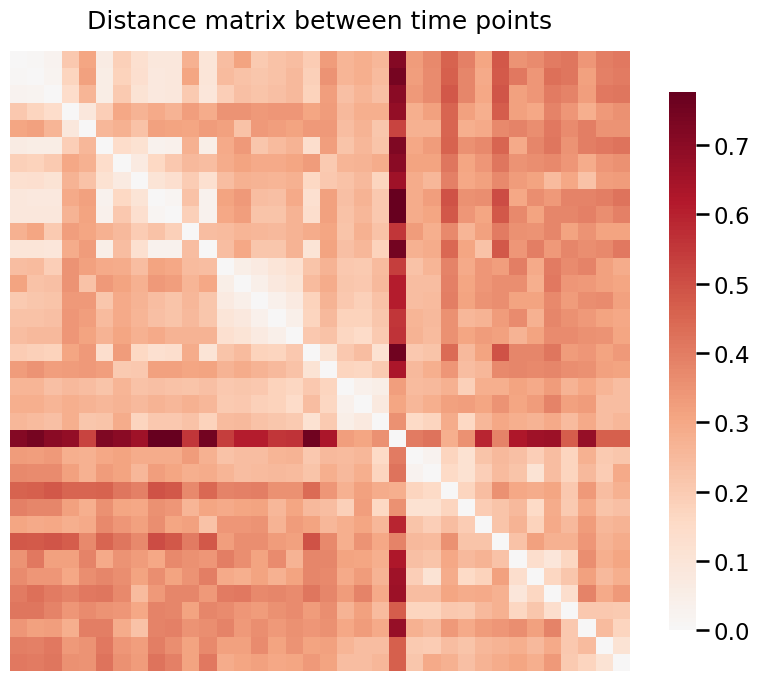

In [12]:
heatmap(D, title="Distance matrix between time points")

Text(0, 0.5, 'eigen value')

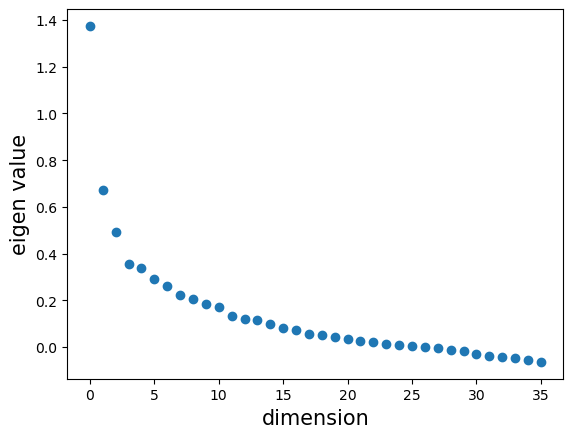

In [13]:
J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

In [14]:
d=3
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

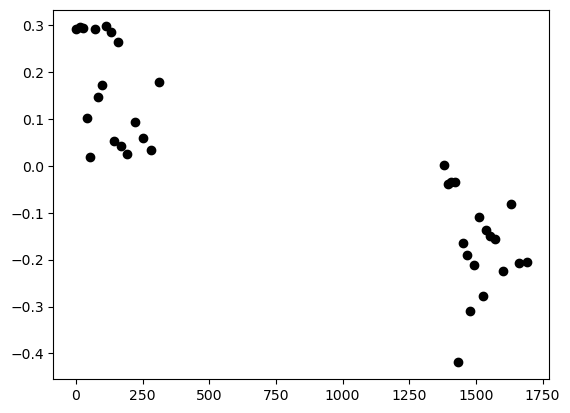

In [15]:
plt.scatter(time_diff,-MDS[:,0],color='black')

Text(0, 0.5, 'dim 2')

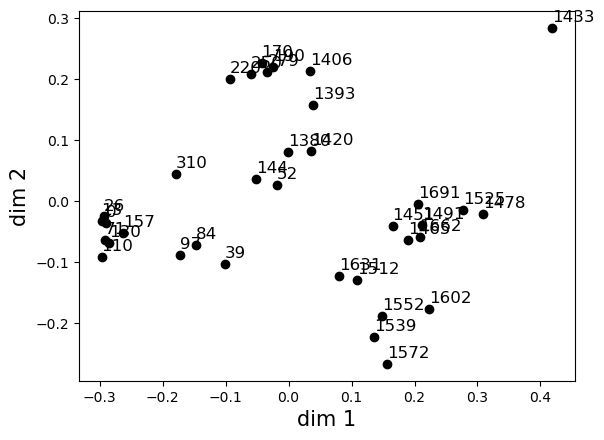

In [16]:
plt.scatter(MDS[:,0],-MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],-MDS[i,1]+0.01,int(time_diff[choosen_time_points[i]]), fontsize=12)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [17]:
optimal_n_neighbors = find_optimal_neighbors(MDS)
embedding = Isomap(n_neighbors=optimal_n_neighbors,n_components=1)
iso = embedding.fit_transform(MDS)

Warning encountered with n_neighbors=2: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Warning encountered with n_neighbors=3: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Warning encountered with n_neighbors=4: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
Successful with n_neighbors=5


In [145]:
#plt.scatter(time_diff,iso)

In [18]:
#pw_fit = piecewise_regression.Fit(time_diff, iso[:,0], n_breakpoints=2)
pw_fit=piecewise_regression.ModelSelection(time_diff, iso[:,0], max_breakpoints=6)


Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     -76.13         True       3.5598 
1                    -86.895         True       2.1632 
2                    -144.19         True      0.36097 
3                    -73.225         True       2.1237 
4                                   False              
5                                   False              
6                                   False              

Min BIC (Bayesian Information Criterion) suggests best model


In [20]:
pw_fit = piecewise_regression.Fit(time_diff, iso[:,0], n_breakpoints=2)

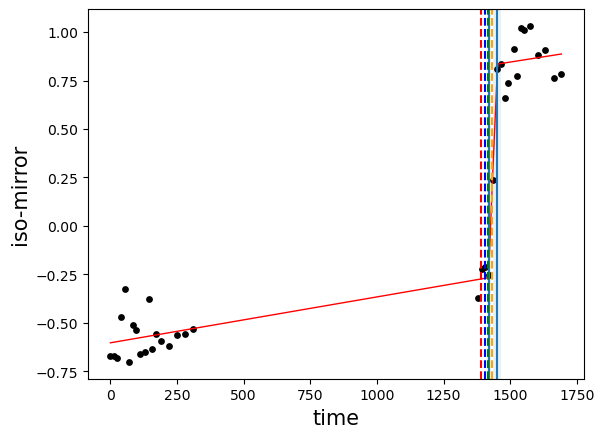

In [21]:
### result for using iso-mirror
pw_fit.plot_data(color='black',s=15)
pw_fit.plot_fit(color="red", linewidth=1)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)


plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

plt.show()
plt.close()

In [142]:
lr = LinearRegression()
lr.fit(np.array(time_diff[:18]).reshape(-1, 1), iso[:18,0])
beta = lr.coef_
beta

array([-0.00106514])

In [146]:
pw_fit=piecewise_regression.ModelSelection(time_diff[18:], iso[18:,0], max_breakpoints=6).models[0]


Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -128.63         True     0.010287 
1                    -172.97         True   0.00063549 
2                    -176.38         True   0.00038121 
3                    -171.49         True    0.0003629 
4                                   False              
5                                   False              
6                                   False              

Min BIC (Bayesian Information Criterion) suggests best model

                    Breakpoint Regression R

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       18\nNo. Model Parameters                    4\nDegrees of Freedom                     14\nRes. Sum of Squares           0.000635491\nTotal Sum of Squares             0.119887\nR Squared                        0.994699\nAdjusted R Squared               0.993068\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                 1.5817       0.0447       35.397      4.24e-15       1.4

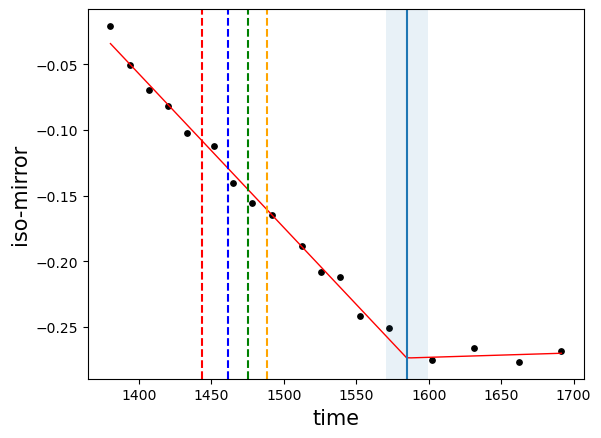

In [147]:
### result for using iso-mirror
pw_fit.plot_data(color='black',s=15)
pw_fit.plot_fit(color="red", linewidth=1)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("time",fontsize=15)
plt.ylabel("iso-mirror",fontsize=15)


plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

plt.show()
plt.close()

In [148]:
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       18
No. Model Parameters                    4
Degrees of Freedom                     14
Res. Sum of Squares           0.000635491
Total Sum of Squares             0.119887
R Squared                        0.994699
Adjusted R Squared               0.993068
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                 1.5817       0.0447       35.397      4.24e-15       1.4859       1.6775
alpha1           -0.00117062     3.03e-05      -38.623      1.26e-15   -0.0012356   -0.0011056
beta1             0.00120444     0.000105       11.419             -   0.00097821    0.0014307
breakpoint1          1584.86         6.71            -             -       1570.5       1599.2
-----------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       18\nNo. Model Parameters                    4\nDegrees of Freedom                     14\nRes. Sum of Squares           0.000635491\nTotal Sum of Squares             0.119887\nR Squared                        0.994699\nAdjusted R Squared               0.993068\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                 1.5817       0.0447       35.397      4.24e-15       1.4